### **Importing Related Notebooks** 

In [2]:
import import_ipynb
import Feature_Engineering

X_trainval = Feature_Engineering.X_trainval
y_trainval = Feature_Engineering.y_trainval
X_test = Feature_Engineering.X_test
y_test = Feature_Engineering.y_test

### **Model Benchmarking**

At this stage, the process of evaluating the performance of various machine learning model algorithms will be carried out by testing each model using various subsets of the available data and calculating the average score used as a reference for the assessment. This method is used to provide a more reliable and accurate estimate of the performance of each machine learning model when faced with new data sets.

This can be done by using method `cross_val_score()` from library **Scikit-learn** which can process cross-validation as many as K-fold or k datasets. The process is repeated k times in which each data set is used as a validation data set in each process. In the end, a series of scores will be generated that can be used to calculate the average score of each machine learning model.

##### **Model Assignment**

First of all, an assignment process will be carried out on various model algorithms to object and ensure that each model that has an input argument of `random_state` will be assigned the number `1995` so that the results from random sampling can be reproduced repeat constantly.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

logit = LogisticRegression(random_state=1995)
knn = KNeighborsClassifier()
svc = SVC(probability=True,random_state=1995)
dt = DecisionTreeClassifier(random_state=1995)
rf = RandomForestClassifier(random_state=1995)
ada = AdaBoostClassifier(random_state=1995)
gb = GradientBoostingClassifier(random_state=1995)
xgb = XGBClassifier()
lgbm = LGBMClassifier(random_state=1995)
mlp = MLPClassifier(random_state=1995,early_stopping=True)

The process of splitting data `X_trainval` and `y_trainval` will be assisted by `StratifiedKFold()` with the input argument `n_splits` of `5`, which means the amount of data to be splitting will be evenly distributed into 5 data clusters with each data set being tested on the model that has been built. The model development process is also carried out iteratively for each model to be tested, including **Logistic Regression**, **K-Nearest Neighbor**, **Support Vector Classifier**, **Decision Tree**, **Random Forest**, **AdaBoost Classifier**, **Gradient Boosting Classifier**, **XGB Classifier**, **LGBM Classifier**, and **Multi-Layer Perceptron**.

##### **Cross Validation Score**

Evaluation Metrics that will be used is `ROC-AUC` which stands for Receiver Operating Characteristic - Area Under the Curve. The measurement result is a single scalar value that represents the overall model performance of each possible threshold value. In addition, it is also good to use when the distribution of target classes is not balanced and the losses from the prediction results false positives and false negatives are not the same. Therefore, the results of this measurement can provide a more robust evaluation of the ability of each model to distinguish between positive and negative classes regardless of the threshold value used.

Apart from that, additional evaluation metrics will also be used, namely Average Precision which is used to measure the ranking quality of an algorithm model by considering precision and recall values. The measurement result is a single scalar value that represents the trade-off of precision and recall values ​​from an algorithm model along the possible threshold values. The results of this measure are useful when faced with unbalanced datasets and the focus is on correctly predicting positive values.

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np

models = {
    'Logistic Regression':logit,
    'K-Nearest Neighbours':knn,
    'Support Vector Classifier':svc,
    'Decision Tree':dt,
    'Random Forest':rf,
    'AdaBoost':ada,
    'Gradient Boosting':gb,
    'eXtreme Gradient Boosting':xgb,
    'Light Gradient Boosting':lgbm,
    'Multi-Layer Perceptron':mlp
}

auc_average, auc_std, ap_average, ap_std = [], [], [], []
skfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1995
)

for i in models.values():
    estimator = Pipeline([('model',i)])

    for i, metric in enumerate([[auc_average,auc_std],[ap_average,ap_std]]):
        cv_score = cross_val_score(
            estimator=estimator,
            X=X_trainval,
            y=y_trainval,
            cv=skfold,
            n_jobs=-1,
            scoring='roc_auc' if i == 0 else 'average_precision',
            error_score=1
        )
        metric[0].append(cv_score.mean())
        metric[1].append(cv_score.std())

result_cv = pd.DataFrame(data={
    ('AUC Score','Average'):auc_average,
    ('AUC Score','STD'):auc_std,
    ('AP Score','Average'):ap_average,
    ('AP Score','STD'):ap_std
})

result_cv = result_cv.set_index(np.array([i for i in models.keys()]))
result_cv = result_cv.sort_values(
    by=('AUC Score','Average'),
    ascending=False
).apply(func=lambda x: round(
    number=x*100,
    ndigits=2
))

result_cv

AUC Score       AP Score      
                            Average   STD  Average   STD
Gradient Boosting             89.06  0.82    69.15  0.86
AdaBoost                      88.69  1.10    68.67  2.08
Logistic Regression           88.44  0.90    68.39  2.09
Multi-Layer Perceptron        88.20  0.78    68.07  1.67
Light Gradient Boosting       87.85  0.69    66.79  0.48
eXtreme Gradient Boosting     87.18  0.64    64.01  1.35
Random Forest                 85.48  1.00    62.49  0.88
Support Vector Classifier     85.00  1.43    65.62  2.03
K-Nearest Neighbours          81.43  1.10    53.87  2.71
Decision Tree                 74.09  2.19    43.19  2.39

It can be seen that from the cross validation score results, the **Gradient Boosting** algorithm model has the best `ROC-AUC` and Average Precision average values ​​and is accompanied by excellent stability. Next, a testing process will be carried out for each algorithm model with test dataset to measure the performance of each.

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc_score, ap_score = [], []

for i in models.values():
    estimator = Pipeline([('model',i)])
    estimator.fit(
        X=X_trainval,
        y=y_trainval
    )

    auc_score.append(roc_auc_score(
        y_true=y_test,
        y_score=estimator.predict_proba(X_test)[:,1]
        ))

    ap_score.append(average_precision_score(
        y_true=y_test,
        y_score=estimator.predict_proba(X_test)[:,1]
    ))

result = pd.DataFrame(data={
    'AUC Score':auc_score,
    'AP Score':ap_score
}).set_index(np.array([i for i in models.keys()]))

result = result.sort_values(
    by='AUC Score',
    ascending=False
).apply(func=lambda x: round(
    number=x*100,
    ndigits=2
))

result

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 881, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 3772, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233563 -> initscore=-1.188300
[LightGBM] [Info] Start training from score -1.188300


,AUC Score,AP Score
Gradient Boosting,89.96,70.24
AdaBoost,89.21,67.90
Multi-Layer Perceptron,89.14,72.01
Logistic Regression,89.09,70.21
Light Gradient Boosting,89.01,68.60
eXtreme Gradient Boosting,87.62,65.53
Random Forest,86.17,66.28
Support Vector Classifier,85.33,70.07
K-Nearest Neighbours,84.91,61.55
Decision Tree,73.50,42.41


It can be seen that the **Gradient Boosting** algorithm model has the best `ROC-AUC` value although Average Precision is not better than **Multi-layer Perceptron**. To make the comparison clearer, a visualization will be carried out as follows.

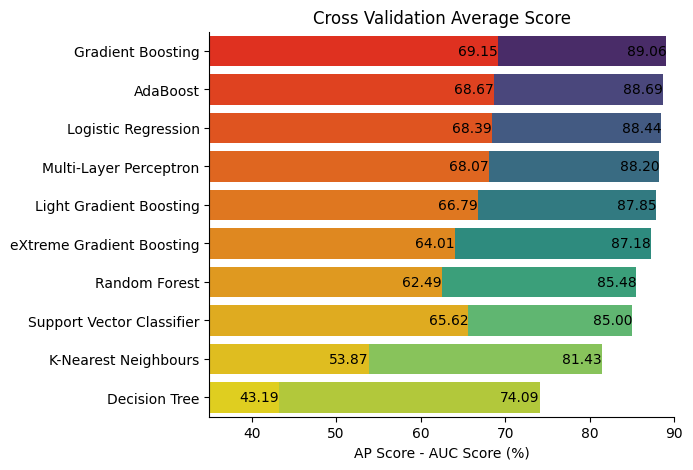

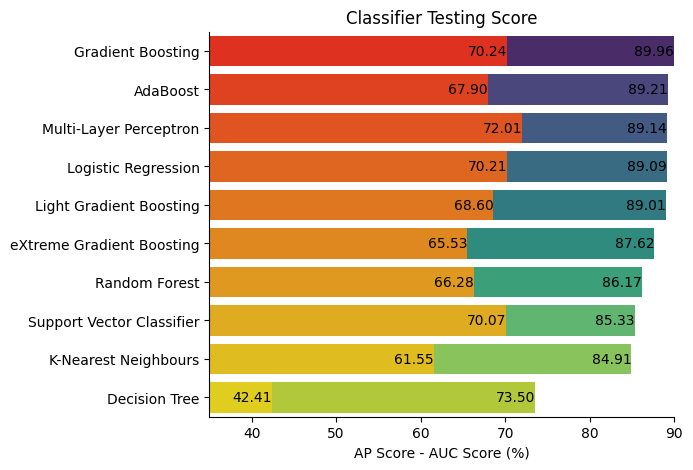

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for j,k in enumerate([[result_cv,('AUC Score','Average'),('AP Score','Average')],[result,'AUC Score','AP Score']]):
    plt.figure(figsize=(6,5))

    for l in range(1,len(k)):
        sns.barplot(
            data=k[0],
            y=k[0].index.values,
            x=k[l],
            palette='viridis' if l == 1 else 'autumn'
        )
        sns.despine()

        for i, val in enumerate(k[0][k[l]]):
            plt.annotate(
                text=f'{val:.2f}',
                xy=(val,i),
                ha='right',
                va='center'
            )

        plt.title('{} Score'.format('Cross Validation Average' if j == 0 else 'Classifier Testing'))
        plt.xlabel('AP Score - AUC Score (%)')
        plt.xlim(35,90)

Based on the visualization above, it can be seen that the **Gradient Boosting** algorithm model has the best performance on the training and validation data sets with slightly better qualified stability as evidenced.

The verdict that will be handed down in the model benchmarking process this time will be on the model with the relatively better `ROC-AUC` and Average Precision performance accompanied by good stability. Therefore, the **Gradient Boosting** algorithm model will be used in the next process of developing the prediction model in this case study.

Next, plotting will be carried out to see the performance and characteristics of the **Gradient Boosting** algorithm model as additional information.

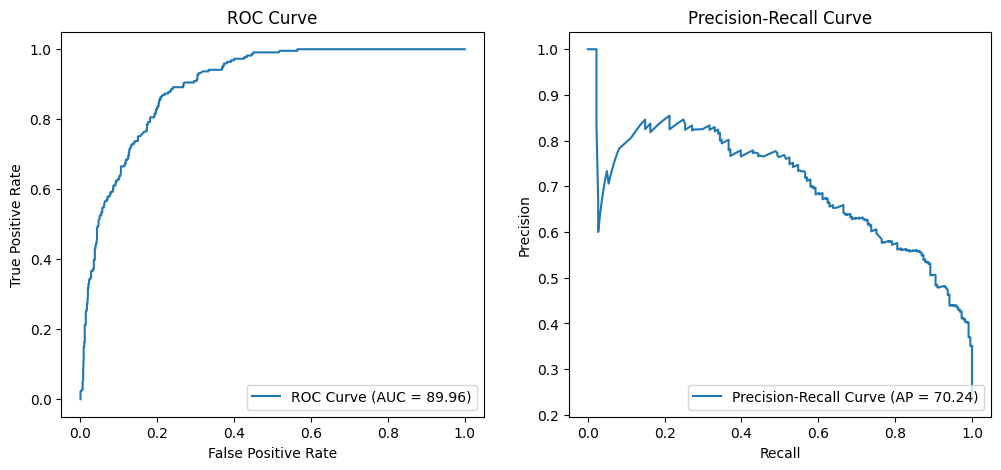

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score 

model = gb.fit(
    X=X_trainval,
    y=y_trainval
)

probabilities = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(
    y_true=y_test,
    y_score=probabilities
)

auc_score = auc(
    x=fpr,
    y=tpr
)

precision, recall, _ = precision_recall_curve(
    y_true=y_test,
    probas_pred=probabilities
)

ap_score = average_precision_score(
    y_true=y_test,
    y_score=probabilities
)

fig, axs = plt.subplots(
    figsize=(12,5),
    ncols=2
)

for i, var in enumerate([
    [fpr,tpr,'ROC','AUC',auc_score,'False Positive Rate','True Positive Rate','ROC Curve'],
    [recall,precision,'Precision-Recall','AP',ap_score,'Recall','Precision','Precision-Recall Curve']
]):
    axs[i].plot(
        var[0],
        var[1],
        label='{} Curve ({} = {})'.format(
            var[2],
            var[3],
            round(
                number=var[4]*100,
                ndigits=2
            )
        )
    )

    axs[i].set_xlabel(var[5])
    axs[i].set_ylabel(var[6])
    axs[i].set_title(var[7])
    axs[i].legend(loc='lower right')

Basically, **Gradient Boosting** belongs to the ensemble method which combines algorithm models with low predictive quality, in this case the trees algorithm model, into a model with good predictive quality. This method is achieved by building additional models which are added based on logical sequence to become a combined or ensemble model. Each algorithm model will be trained to focus on the results of observations that were incorrectly predicted by the previous algorithm model. This learning method is known as boosting algorithm which can combine the results of predictions from weak algorithm models into a weighted total value to achieve the final result of a better prediction.

On the one hand, **Gradient Boosting** is equipped with gradient descent optimization capability which is used to minimize loss function. This algorithm will work iteratively to adapt poor algorithm models to the negative gradient value of a loss function sequentially to become a combined prediction result. This process aims to find the optimal weight value of the entire process of combining the weak algorithm models.